# Gene Finding with Individual Networks

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import torch.nn as nn
import torch.nn.functional as F
from single_task.NoDA_base.relu_models import FeatureExtractor, LabelRegressor

from jupyter_utils import AllDataset

data_dir = '../drp-data/'
GDSC_GENE_EXPRESSION = 'preprocessed/gdsc_tcga/gdsc_rma_gene_expr.csv'
TCGA_GENE_EXPRESSION = 'preprocessed/gdsc_tcga/tcga_log2_gene_expr.csv'

TCGA_TISSUE = 'preprocessed/tissue_type/TCGA_tissue_one_hot.csv'
GDSC_TISSUE = 'preprocessed/tissue_type/GDSC_tissue_one_hot.csv'

GDSC_lnIC50 = 'preprocessed/drug_response/gdsc_lnic50.csv'
TCGA_DR = 'preprocessed/drug_response/tcga_drug_response.csv'

dataset = AllDataset(data_dir, GDSC_GENE_EXPRESSION, TCGA_GENE_EXPRESSION, 
                     GDSC_lnIC50, TCGA_DR, TCGA_TISSUE)

In [2]:
drug = 'tamoxifen'
gdsc_expr, gdsc_dr, train_tcga_expr, test_tcga_expr = dataset.filter_and_normalize_data(drug)

In [3]:
test_tissue = dataset.tcga_tissue.loc[test_tcga_expr.index]
tissue_list = [t for t in test_tissue.columns if test_tissue[t].sum() > 0]
test_tissue = test_tissue[tissue_list]

meta = pd.DataFrame(index=test_tcga_expr.index, columns=['tissue', 'label'])
for tissue in test_tissue.columns:
    x = test_tissue.loc[test_tissue[tissue] == 1].index
    meta.loc[x, 'tissue'] = tissue

meta['label'] = dataset.tcga_dr.loc[test_tcga_expr.index][drug]
print(test_tissue.sum(axis=0))

Breast         17
Soft Tissue     2
Skin            1
dtype: int64


In [4]:
from gene_finding.models import load_model

In [5]:
n_seeds = 10
models = []
outputs = pd.DataFrame(index=test_tcga_expr.index, columns=range(1,n_seeds+1))
x = torch.FloatTensor(test_tcga_expr.values)

for i in range(1, n_seeds+1):
    mod = load_model(seed=i,drug=drug,n_genes=len(dataset.genes))
    mod.eval()
    models.append(mod)
    outputs[i] = mod(x).detach().numpy()

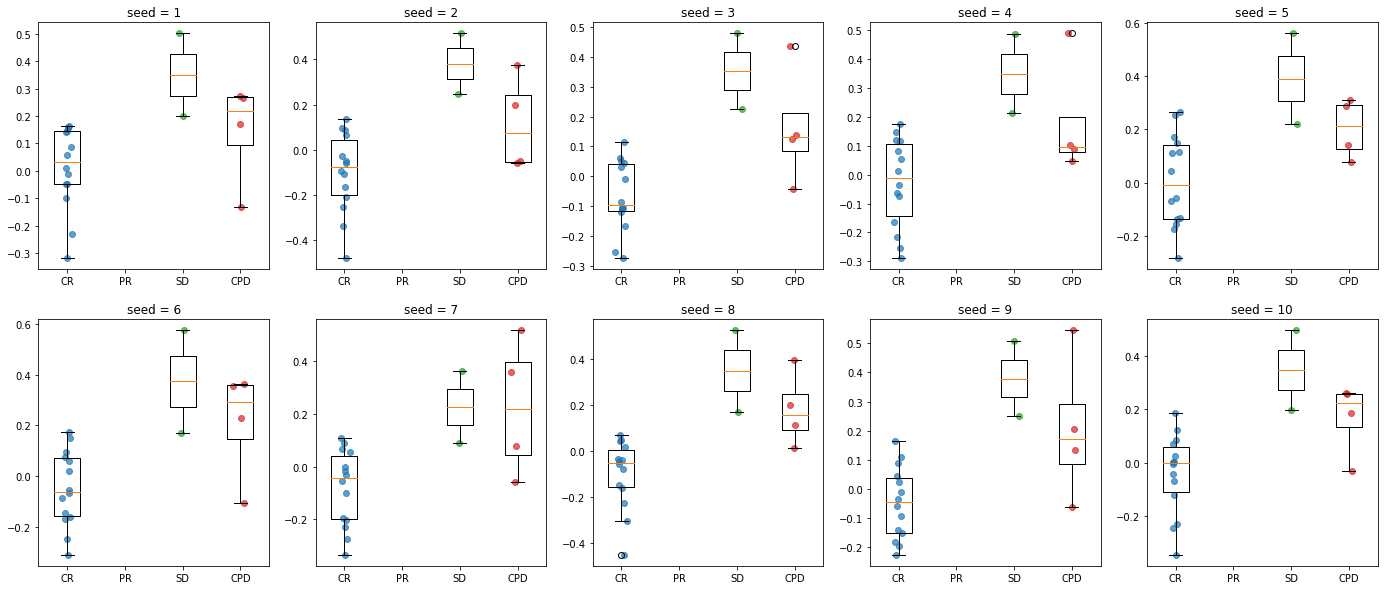

In [6]:
ctg = ["Complete Response", "Partial Response", "Stable Disease", "Clinical Progressive Disease"]
response = ['CR', 'PR', 'SD', 'CPD']

fig, axes = plt.subplots(2, 5, figsize=(24, 10))

for i in range(1, 11):
    ax = axes[(i-1)//5][(i-1)%5]

    boxes = []
    for c in ctg:
        x = meta.loc[meta['label'] == c].index
        boxes.append(outputs.loc[x][i])

    ax.boxplot(boxes)    

    for j, box in enumerate(boxes):
        y = box.values
        x = np.random.normal(j+1, 0.04, size=len(y))
        ax.scatter(x, y, alpha=0.7)

    ax.set_xticklabels(response)
    ax.set_title('seed = %d'%i)

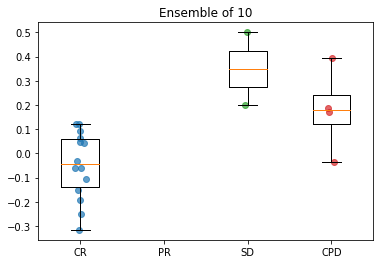

In [7]:
label = dataset.tcga_dr.loc[test_tcga_expr.index]
boxes = []
for c in ctg:
    x = label.loc[label[drug] == c].index
    boxes.append(outputs.loc[x].mean(axis=1))

fig, ax = plt.subplots()
ax.boxplot(boxes)    

for i, box in enumerate(boxes):
    y = box.values
    x = np.random.normal(i+1, 0.04, size=len(y))
    ax.scatter(x, y, alpha=0.7)

ax.set_xticklabels(response)
ax.set_title("Ensemble of 10")
plt.show()

## Load CXPlain

In [8]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
tf.random.set_seed(1)
from tensorflow.python.keras.losses import mean_squared_error as loss
from cxplain import MLPModelBuilder, CXPlain

Instructions for updating:
non-resource variables are not supported in the long term


In [9]:
exp_ens = CXPlain.load('gene_finding/results/CX_ens1/%s/explainer'%drug, relpath=True)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
attr_ens = exp_ens.explain(test_tcga_expr.values)
attr_ens = pd.DataFrame(attr_ens, index=test_tcga_expr.index, columns=dataset.hgnc)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [11]:
exp = CXPlain.load('gene_finding/results/CX_ind1/tamoxifen/seed1/explainer/', relpath=True)

In [13]:
attr_ind = []

for seed in range(1, 11):
    exp = CXPlain.load('gene_finding/results/CX_ind1/%s/seed%d/explainer'%(drug,seed), relpath=True)
    attr = exp.explain(test_tcga_expr.values)
    attr = pd.DataFrame(attr, index=test_tcga_expr.index, columns=dataset.hgnc)
    attr_ind.append(attr)

In [14]:
len(attr_ind)

10

In [19]:
spear = np.zeros((10, len(attr.index)))
for seed in range(10):
    for i, idx in enumerate(attr.index):
        spear[seed, i] = spearmanr(attr_ind[seed].loc[idx], np.abs(test_tcga_expr.loc[idx]))[0]

In [23]:
spear = pd.DataFrame(spear)
spear

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.004177,0.062280,0.051949,-0.003813,-0.005740,0.051378,0.012700,0.009522,0.021224,-0.007342,0.039511,0.068543,-0.018693,-0.005468,0.000264,0.019909,-0.000816,0.003394,0.036518,0.053408
1,-0.012980,0.049924,0.053134,-0.029879,-0.015718,0.034384,0.011988,0.008797,0.014442,-0.007316,0.029429,0.065885,-0.022897,-0.013494,0.002070,-0.001646,-0.003562,0.004526,0.010423,0.027300
2,-0.010650,0.045229,0.042788,-0.022747,-0.001513,0.033156,-0.012297,-0.000444,0.017442,-0.005586,0.006770,0.059468,-0.021326,-0.018991,-0.012579,0.016309,0.005814,-0.017816,-0.003564,0.026272
3,0.002776,0.058592,0.048795,-0.008673,-0.002561,0.043501,0.010736,0.000241,0.027023,0.001038,0.019234,0.045199,-0.008540,-0.026903,-0.002616,0.010639,-0.006611,-0.002105,-0.002406,0.046953
4,-0.007990,0.033158,0.061093,-0.000613,-0.019663,0.040745,-0.010990,0.017807,0.023398,-0.000661,0.071834,0.038918,-0.037566,-0.024718,-0.030920,0.028238,-0.008991,0.006731,0.004008,0.003784
5,0.002988,0.050342,0.064518,-0.006697,-0.012300,0.069328,0.008426,-0.009183,0.009489,0.007826,0.023958,0.061788,0.004142,0.011554,-0.004510,0.028057,0.004159,0.005260,0.021100,0.009726
6,-0.007707,0.029445,0.041707,-0.009862,-0.004461,0.042531,-0.007630,0.013594,0.015425,-0.009640,0.017386,0.055835,-0.025990,-0.010984,0.004236,0.006019,-0.001152,-0.027786,-0.024662,0.019892
7,0.007260,0.060833,0.028767,-0.006187,-0.006440,0.040907,-0.000940,0.031215,0.064090,-0.008527,0.052104,0.065326,-0.023457,-0.040131,-0.019509,0.018592,0.001183,-0.028996,-0.000233,0.043952
8,0.016218,0.044809,0.069086,-0.015875,-0.013839,0.080101,-0.012417,0.013525,0.012363,-0.011553,0.078457,0.069585,-0.025044,-0.020868,-0.019059,0.016730,-0.003257,0.036202,-0.001301,0.044771
9,-0.012936,0.058056,0.052817,-0.011754,-0.001648,0.086413,-0.014686,0.013383,0.028122,-0.002531,0.068631,0.047659,-0.011214,-0.018494,-0.014654,0.012384,0.009048,-0.004989,0.009214,0.036665


**NOTE:** Attribution is not correlated with expression for all of the seeds

# Correlation of Each seed's attributions

In [28]:
idx = test_tcga_expr.index[0]

In [31]:
spearman_matrix = np.zeros((10,10))
for i in range(10):
    for j in range(i, 10):
        spearman_matrix[i, j] = spearmanr(attr_ind[i].loc[idx].values, attr_ind[j].loc[idx].values)[0]

In [33]:
pd.DataFrame(spearman_matrix)

,0,1,2,3,4,5,6,7,8,9
0,1.0,0.347142,0.313669,0.306378,0.317678,0.350240,0.267643,0.312357,0.325988,0.348947
1,0.0,1.000000,0.316389,0.313082,0.334628,0.360105,0.288107,0.300700,0.302206,0.364420
2,0.0,0.000000,1.000000,0.318103,0.327535,0.299474,0.299754,0.308323,0.319518,0.325078
3,0.0,0.000000,0.000000,1.000000,0.318894,0.273760,0.300055,0.317179,0.316393,0.302612
4,0.0,0.000000,0.000000,0.000000,1.000000,0.340954,0.315791,0.270538,0.283751,0.346021
5,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.273043,0.260715,0.297952,0.375817
6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.280527,0.286163,0.293890
7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.308886,0.289380
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.308343
9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


# Mean individual seed attribution vs Ensemble Attribution

In [37]:
attr_mis = pd.DataFrame(np.zeros(attr_ens.shape), index=attr_ens.index, columns=attr_ens.columns)
for i in range(10):
    attr_mis += attr_ind[i]
attr_mis /= 10

In [41]:
for i in attr_mis.index:
    print(spearmanr(attr_mis.loc[i], attr_ens.loc[i]))

SpearmanrResult(correlation=0.6006820160893178, pvalue=0.0)
SpearmanrResult(correlation=0.6188539259735432, pvalue=0.0)
SpearmanrResult(correlation=0.6459345799478972, pvalue=0.0)
SpearmanrResult(correlation=0.5654401573489545, pvalue=0.0)
SpearmanrResult(correlation=0.7506542081676386, pvalue=0.0)
SpearmanrResult(correlation=0.6063629576137128, pvalue=0.0)
SpearmanrResult(correlation=0.7538435391590677, pvalue=0.0)
SpearmanrResult(correlation=0.7034197752388917, pvalue=0.0)
SpearmanrResult(correlation=0.6130038782079706, pvalue=0.0)
SpearmanrResult(correlation=0.41537867869988127, pvalue=0.0)
SpearmanrResult(correlation=0.5795435248180061, pvalue=0.0)
SpearmanrResult(correlation=0.7882104544252593, pvalue=0.0)
SpearmanrResult(correlation=0.6606455699522333, pvalue=0.0)
SpearmanrResult(correlation=0.6165072727827191, pvalue=0.0)
SpearmanrResult(correlation=0.6117379479413648, pvalue=0.0)
SpearmanrResult(correlation=0.6807365542276761, pvalue=0.0)
SpearmanrResult(correlation=0.656725839

## get top 200 (mean and borda)

In [42]:
from gene_finding.borda import rank_aggregate_Borda
def get_ranked_list(attr, k=200):
    attr = np.abs(attr.T)
    sorted_list = []

    for sample in attr.columns:
        rank = attr.sort_values(sample, ascending=False).index # highest to lowest
        sorted_list.append(rank)

    agg_genes = rank_aggregate_Borda(sorted_list, k, 'geometric_mean')

    return agg_genes

In [43]:
attr_ens_mean = list(attr_ens.mean(axis=0).nlargest(200).index)
attr_mis_mean = list(attr_mis.mean(axis=0).nlargest(200).index)

In [47]:
attr_ens_borda = get_ranked_list(attr_ens)
attr_mis_borda = get_ranked_list(attr_mis)

In [45]:
len(set(attr_ens_mean).intersection(set(attr_mis_mean)))/len(set(attr_ens_mean).union(set(attr_mis_mean)))

0.5037593984962406

In [48]:
len(set(attr_ens_borda).intersection(set(attr_mis_borda)))/len(set(attr_ens_borda).union(set(attr_mis_borda)))

0.5209125475285171

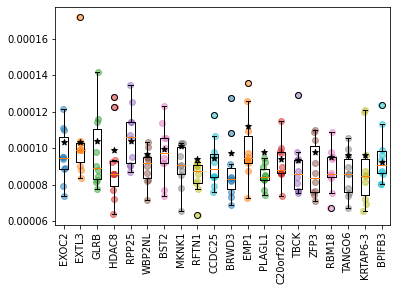

In [68]:
fig, ax = plt.subplots()

n_genes = 20
boxes = []
for gene in attr_ens_borda[:n_genes]:
    elems = []
    for i in range(10):
        elems.append(attr_ind[i][gene].mean())
    boxes.append(elems)
    
ax.boxplot(boxes)
for i, box in enumerate(boxes):
    x = np.random.normal(i+1, 0.04, size=len(boxes[i]))
    ax.scatter(x, boxes[i], alpha=0.5)

ax.scatter(range(1,n_genes+1), attr_ens[attr_ens_borda[:n_genes]].mean(), marker='*', color='black')
    
ax.set_xticklabels(attr_ens_borda[:n_genes], rotation='vertical')
plt.show()